# Getting Started

This guide will make use of the dataset generated with the Commercial Modular Aero-Propulsion System Simulation (C-MAPSS) dynamical model.
The dataset consists of multiple multivariate time series. Each data set is further divided into training and test subsets. Each time series is from a different engine - i.e., the data can be considered to be from a fleet of engines of the same type. Each engine starts with different degrees of initial wear and manufacturing variation which is unknown to the user. This wear and variation are considered normal, i.e., it is not considered a fault condition. There are three operational settings that have a substantial effect on engine performance. These settings are also included in the data. The data are contaminated with sensor noise.

The engine is operating normally at the start of each time series and starts to degrade at some point during the series. In the training set, the degradation grows in magnitude until a predefined threshold is reached beyond which it is not preferable to operate the engine. In the test set, the time series ends some time prior to complete degradation. The objective of the competition is to predict the number of operational cycles after the last cycle that the engine will continue to operate properly.

The data are provided as a zip-compressed text file with 26 columns of numbers, separated by spaces. Each row is a snapshot of data taken during a single operational cycle; each column is a different variable.

Dataset structure

* Unit: Engine number [-]
* t: time [cycles]
* 0p1: operational setting 1
* op2: operational setting 2
* op3: operational setting 3
* s1: Sensor measurement 1
* s2: Sensor measurement 2
...
* s20: sensor measurement 20


In the first set of data, there are 100 train trajectories and 100 test trajectories.



[1] A. Saxena, M. Ieee, K. Goebel, D. Simon, and N. Eklund, “Damage Propagation Modeling for Aircraft Engine Prognostics,” Response, 2008. 

## Import

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf


sns.set()




2022-08-03 18:45:57.999576: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-08-03 18:45:58.002315: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-03 18:45:58.002325: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Dataset

In [3]:
from ceruleo.dataset.catalog.CMAPSS import CMAPSSDataset

train_dataset = CMAPSSDataset(train=True, models='FD001')
validation_dataset = CMAPSSDataset(train=False, models='FD001')

### Number of lives in the training set

In [4]:
len(train_dataset)

100

### Number of lives in the validation set

In [5]:
len(validation_dataset)

100

## Visualization

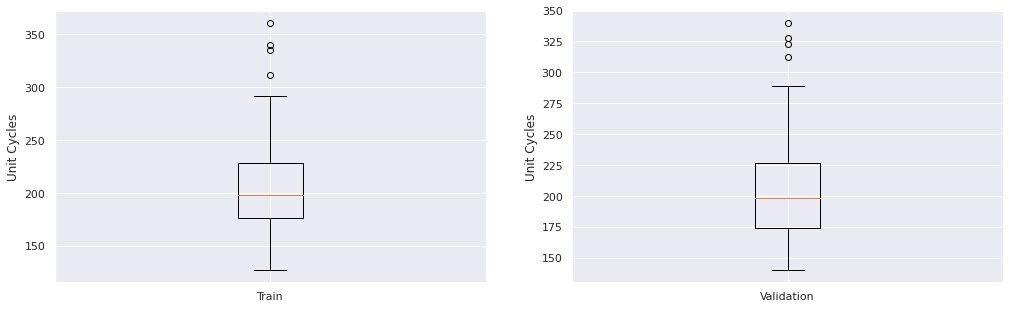

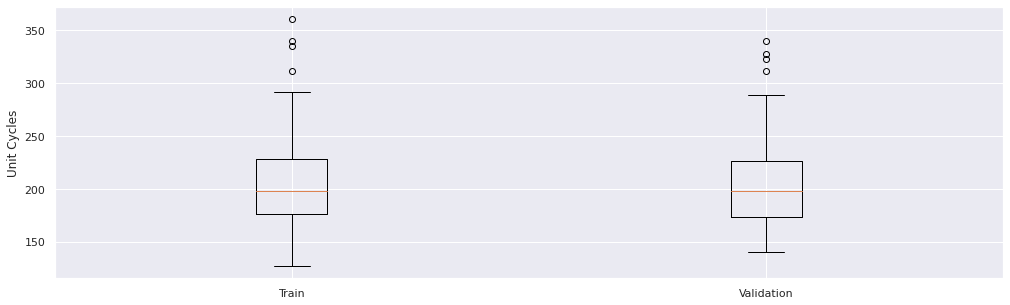

In [6]:
from ceruleo.graphics.duration import durations_boxplot

fig, ax = plt.subplots(1, 2, figsize=(17, 5))
durations_boxplot(train_dataset, 
                  xlabel='Train', 
                  ylabel='Unit Cycles', 
                  ax=ax[0])
durations_boxplot(validation_dataset, 
                  xlabel='Validation', 
                  ylabel='Unit Cycles', 
                  ax=ax[1]);

ax = durations_boxplot([train_dataset, validation_dataset], 
                  xlabel=['Train', 'Validation'], 
                  ylabel='Unit Cycles',
                  figsize=(17, 5))

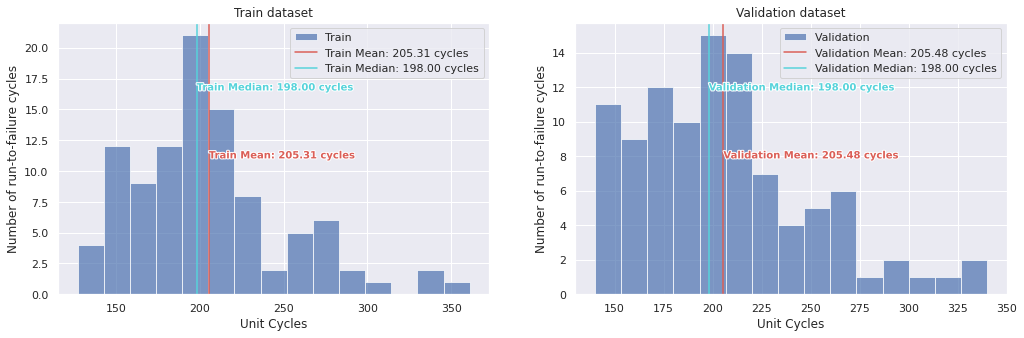

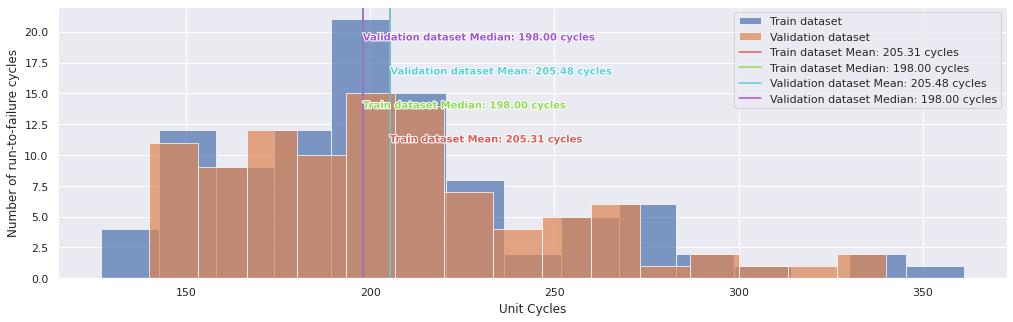

In [7]:
from ceruleo.graphics.duration import durations_histogram

fig, ax = plt.subplots(1, 2, figsize=(17, 5))
durations_histogram(train_dataset, 
                         label='Train',
                         xlabel='Unit Cycles', 
                         units='cycles',
                         alpha=0.7,
                         ax=ax[0])
ax[0].set_title('Train dataset')
durations_histogram(validation_dataset, 
                         label='Validation',
                         xlabel='Unit Cycles', 
                         units='cycles',
                         alpha=0.7,
                         ax=ax[1])
ax[1].set_title('Validation dataset');

durations_histogram([train_dataset,validation_dataset], 
                 label=['Train dataset','Validation dataset'],
                 xlabel='Unit Cycles', 
                 alpha=0.7,
                 units='cycles',
                 figsize=(17, 5));

## Transformers

There are two ways of defining a transformer. The first way is more similar to the scikit-learn Pipeline API, and the other one is similar to the tensorflow functional API.
Two pipelines have to be defined:
* How the data is going to be transformed
    * This transformer invovles selecting and transforming and generating features
* How the target is going to be transformed
    * This transformer involves selecting and transforming the target

The base class of the pipeline is the `LivesPipeline` class. This class is an extension of `sklearn.pipeline.Pipeline` and change the way the data is fitted. 
Each transformer class inherit from the `TransformerStep`. This class implements the method `partial_fit` which receives the data belonging to the whole life and update its internal state accordingly.

### Functional API

Following the literature, the future that addresses this dataset, only a subset of the feature are going to be used to fit our model.

In [8]:
from ceruleo.dataset.catalog.CMAPSS import sensor_indices
features = [train_dataset[0].columns[i] for i in sensor_indices]
features

['SensorMeasure2',
 'SensorMeasure3',
 'SensorMeasure4',
 'SensorMeasure7',
 'SensorMeasure8',
 'SensorMeasure9',
 'SensorMeasure11',
 'SensorMeasure12',
 'SensorMeasure13',
 'SensorMeasure14',
 'SensorMeasure15',
 'SensorMeasure17',
 'SensorMeasure20',
 'SensorMeasure21']

The transformation of the input data will be simple, a feature scaling between -1 and 1 and imputing any missing value or non finite.

In [9]:
from ceruleo.transformation.features.selection import ByNameFeatureSelector
from ceruleo.transformation.features.scalers import MinMaxScaler
from ceruleo.transformation.features.imputers import MeanImputer

functional_pipe = ByNameFeatureSelector(features=features)
functional_pipe = MinMaxScaler(range=(-1,1))(functional_pipe)
functional_pipe = MeanImputer()(functional_pipe)

One common approach for handling PM problems is to downplay the early stages of the execution due to the fact that that is harder to detect indication of degradation at the beggining.

For this dataset, a piece-wise linear degradation model has been validated to be suitable and effective. In general, the engine unit works normally in the early age and degrades linearly afterwards. It is assumed to have a constant RUL label in the initial period.  [1]

[1] Li, X., Ding, Q., & Sun, J. Q. (2018). Remaining useful life estimation in prognostics using deep convolution neural networks. Reliability Engineering & System Safety, 172, 1-11.

In [10]:
from ceruleo.transformation.target import PicewiseRUL

target_pipe = ByNameFeatureSelector(features=['RUL'])
target_pipe = PicewiseRUL(max_life=125)(target_pipe)

In [11]:
from ceruleo.transformation.functional.transformers import Transformer
functional_transformer = Transformer(
    transformerX=functional_pipe,
    transformerY=target_pipe)


### Fitting the transformer

The transformer must be fitted on the dataset.

In [13]:
functional_transformer.fit(train_dataset)
train_transformed_ds = train_dataset.map(functional_transformer)
val_transformed_ds = validation_dataset.map(functional_transformer)
X, y, sw = train_transformed_ds[0]

### Transforming a life

In [14]:
X.shape

(192, 14)

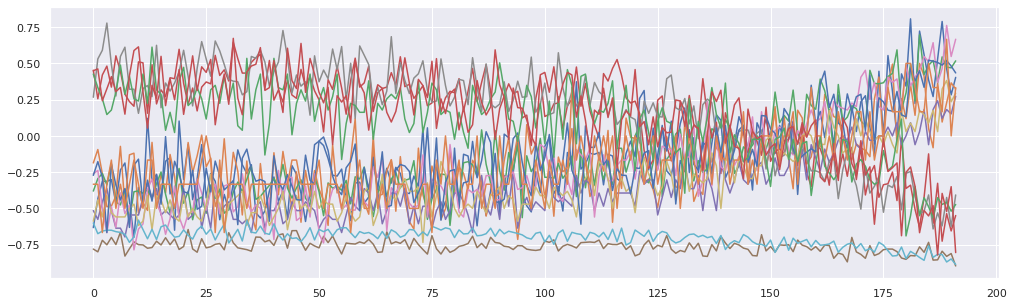

In [15]:
fig, ax = plt.subplots(figsize=(17, 5))
ax.plot(X);

## Iterators

### Lives iterator

The dataset can be iterated. Each element of the iteration is life in stored in `pd.DataFrame` which contains all the features

In [16]:
train_dataset[0].columns

Index(['Cycle', 'OpSet1', 'OpSet2', 'OpSet3', 'SensorMeasure1',
       'SensorMeasure2', 'SensorMeasure3', 'SensorMeasure4', 'SensorMeasure5',
       'SensorMeasure6', 'SensorMeasure7', 'SensorMeasure8', 'SensorMeasure9',
       'SensorMeasure10', 'SensorMeasure11', 'SensorMeasure12',
       'SensorMeasure13', 'SensorMeasure14', 'SensorMeasure15',
       'SensorMeasure16', 'SensorMeasure17', 'SensorMeasure18',
       'SensorMeasure19', 'SensorMeasure20', 'SensorMeasure21', 'RUL',
       'OpMode', 'Engine'],
      dtype='object')

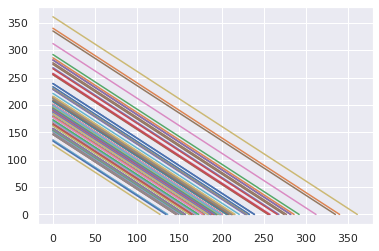

In [17]:
fig, ax = plt.subplots()
for life in train_dataset:
    ax.plot(life['RUL'].values)

### WindowedDatasetIterator
The windowed dataset iterator provides a way of iterating the transformed dataset trough an sliding window. The sample for the i-th element, provides the (window-1) elements of the window. It also provides capabilities to shuffle in diverse ways the how the samples are delivered by the iterator.

In [50]:
from ceruleo.iterators.iterators import WindowedDatasetIterator
from ceruleo.iterators.shufflers import AllShuffled, NotShuffled
from sklearn.model_selection import train_test_split


val_transformed_ds, test_transformed_ds = train_test_split(val_transformed_ds, train_size=0.50)

window = 15
train_iterator = WindowedDatasetIterator(
    train_transformed_ds,
    window,
    step=1,
    horizon=1,
    shuffler=NotShuffled())

val_iterator = WindowedDatasetIterator(
    val_transformed_ds,
    window,
    step=1,
    horizon=1,
    shuffler=NotShuffled())

test_iterator = WindowedDatasetIterator(
    test_transformed_ds,
    window,
    step=1,
    horizon=1,
    shuffler=NotShuffled())

Since we are using the functional_transformer that only has 14 feature and a window size of 7 samples. The output of one element of the iterator wil be a matrix ox size (7 x14)

In [51]:
X.shape

(192, 14)

## Model

### Keras models

Let's create a simple model in keras with some FC layers. 


First of all we need to create two batchers for feeding the model.

A simple fully connected model is already implemented in the library. You can specify the number of layers and the hidden dimension

In [52]:
import tensorflow as tf


inputs = tf.keras.Input(shape=train_iterator.shape)
x = tf.keras.layers.Flatten()(inputs)
x = tf.keras.layers.Dense(32, activation=tf.nn.relu)(x)
outputs = tf.keras.layers.Dense(1, activation=tf.nn.relu)(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(loss='mae', weighted_metrics=[])
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 15, 14)]          0         
                                                                 
 flatten_4 (Flatten)         (None, 210)               0         
                                                                 
 dense_8 (Dense)             (None, 32)                6752      
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 6,785
Trainable params: 6,785
Non-trainable params: 0
_________________________________________________________________


In [53]:
from ceruleo.models.keras.dataset import tf_regression_dataset

tf_train_data = tf_regression_dataset(train_iterator).batch(16)
tf_val_data = tf_regression_dataset(val_iterator).batch(16)
history = model.fit(tf_train_data, validation_data=tf_val_data, epochs=25)

Epoch 1/25
1202/1202 [==============================] - 6s 5ms/step - loss: 26.4441 - val_loss: 9.0626
Epoch 2/25
1202/1202 [==============================] - 7s 5ms/step - loss: 16.8700 - val_loss: 9.1945
Epoch 3/25
1202/1202 [==============================] - 10s 8ms/step - loss: 16.3562 - val_loss: 9.1336
Epoch 4/25
1202/1202 [==============================] - 9s 8ms/step - loss: 15.8311 - val_loss: 9.2630
Epoch 5/25
1202/1202 [==============================] - 9s 7ms/step - loss: 15.2349 - val_loss: 9.6694
Epoch 6/25
1202/1202 [==============================] - 9s 7ms/step - loss: 14.7655 - val_loss: 10.3837
Epoch 7/25
1202/1202 [==============================] - 9s 7ms/step - loss: 14.3822 - val_loss: 10.6509
Epoch 8/25
1202/1202 [==============================] - 9s 7ms/step - loss: 14.0275 - val_loss: 10.8139
Epoch 9/25
1202/1202 [==============================] - 12s 10ms/step - loss: 13.7294 - val_loss: 10.8586
Epoch 10/25
1202/1202 [==============================] - 10s 8ms/s

#### Learning curves

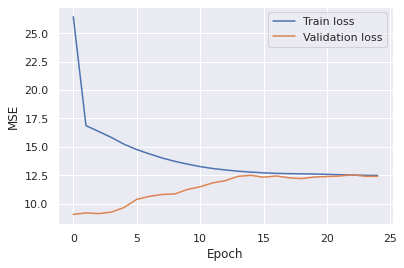

In [54]:
fig, ax = plt.subplots()
ax.plot(history.history['loss'], label='Train loss')
ax.plot(history.history['val_loss'], label='Validation loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE')
ax.legend()

#### Prediction on the test set

6/6 [==============================] - 0s 16ms/step


<AxesSubplot:xlabel='Hours [h]', ylabel='Hours [h]'>

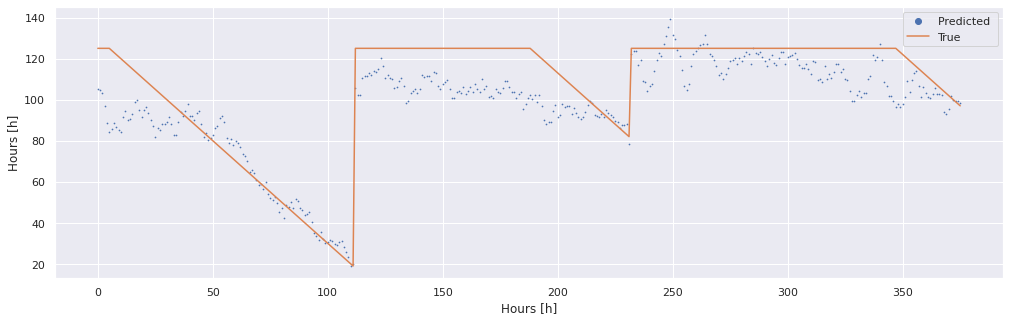

In [55]:
from ceruleo.iterators.utils import true_values

from ceruleo.graphics.plots import plot_predictions, PredictionResult, plot_predictions_grid

tf_test_data = tf_regression_dataset(test_iterator).batch(64)

result_fc = PredictionResult(
    "Fuly connected model",    
    true_values(tf_test_data),
    model.predict(tf_test_data)
)
plot_predictions(result_fc, figsize=(17, 5), plot_fitted=False)




(<Figure size 1224x720 with 3 Axes>,
 array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object))

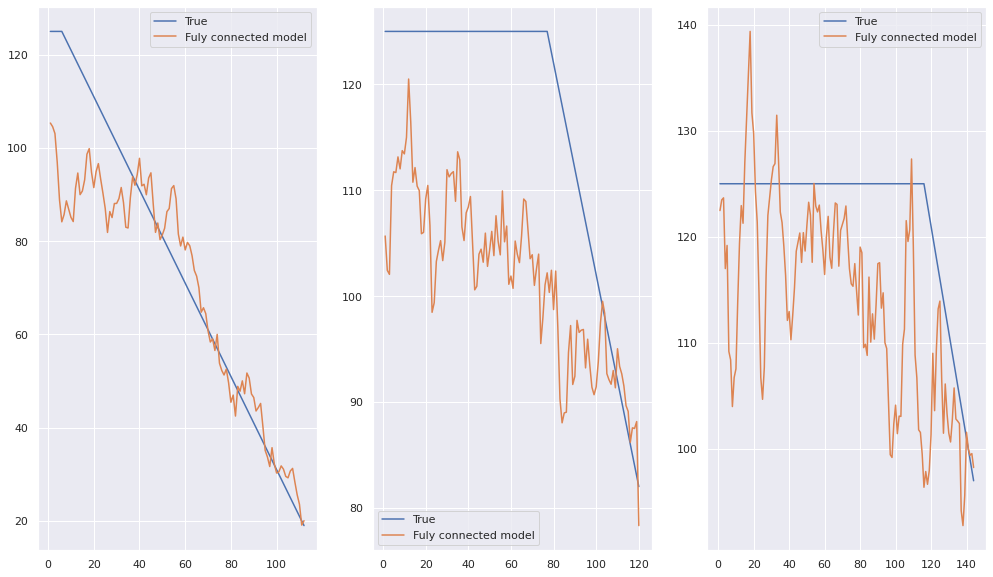

In [56]:
plot_predictions_grid(result_fc, figsize=(17, 10))

## A more complex model

We can use the model defined in the article "Remaining useful life estimation in prognostics using deep convolution neural networks" by Xiang Lia, Qian Ding and Jian-Qiao Sun already defined in the library.

In [57]:
from tensorflow.keras.callbacks import LearningRateScheduler

from ceruleo.models.keras.losses import root_mean_squared_error

from ceruleo.models.keras.models.XiangQiangJianQiao import XiangQiangJianQiaoModel

def scheduler(epoch, lr):
    """Learning rate as reported in the article"""
    if epoch < 17:
        return 0.001
    else:
        return 0.0001


model = XiangQiangJianQiaoModel(train_iterator.shape)
model.compile(loss=root_mean_squared_error, 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
             weighted_metrics=[])
history = model.fit(tf_train_data, 
                    validation_data=tf_val_data,  
                    epochs=25, 
                    callbacks=[LearningRateScheduler(scheduler, verbose=True)])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/25
1202/1202 [==============================] - 8s 6ms/step - loss: 41.7871 - val_loss: 26.7887 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/25
1202/1202 [==============================] - 12s 10ms/step - loss: 19.8615 - val_loss: 11.7442 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/25
1202/1202 [==============================] - 15s 12ms/step - loss: 17.1115 - val_loss: 9.5570 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/25
1202/1202 [==============================] - 13s 11ms/step - loss: 16.5795 - val_loss: 9.6201 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/25
1202/1202 [==============================] - 13s 11ms/step - loss: 16.3705 - val_loss: 9.5339 - lr: 0.0010

Epoch 6: LearningRateScheduler setting learning rate to 0.001.
Epoch 6/25
1202/1202 [====

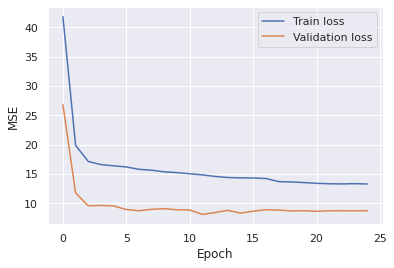

In [58]:
fig, ax = plt.subplots()
ax.plot(history.history['loss'], label='Train loss')
ax.plot(history.history['val_loss'], label='Validation loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE')
ax.legend()

6/6 [==============================] - 0s 18ms/step


<AxesSubplot:xlabel='Hours [h]', ylabel='Hours [h]'>

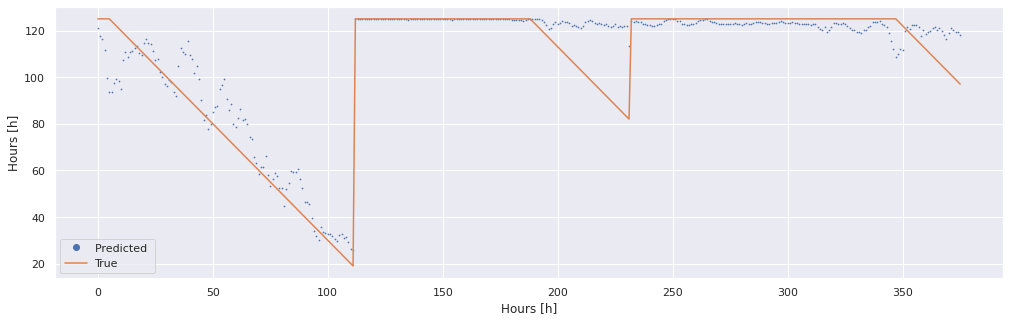

In [59]:
from ceruleo.iterators.utils import true_values

from ceruleo.graphics.plots import plot_predictions, PredictionResult, plot_predictions_grid

tf_test_data = tf_regression_dataset(test_iterator).batch(64)

result_xqjq = PredictionResult(
    "XiangQiangJianQiaoModel",    
    true_values(tf_test_data),
    model.predict(tf_test_data)
)
plot_predictions(result_xqjq, figsize=(17, 5), plot_fitted=False)


In [ ]:
## Comparison

(<Figure size 1224x648 with 3 Axes>,
 array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object))

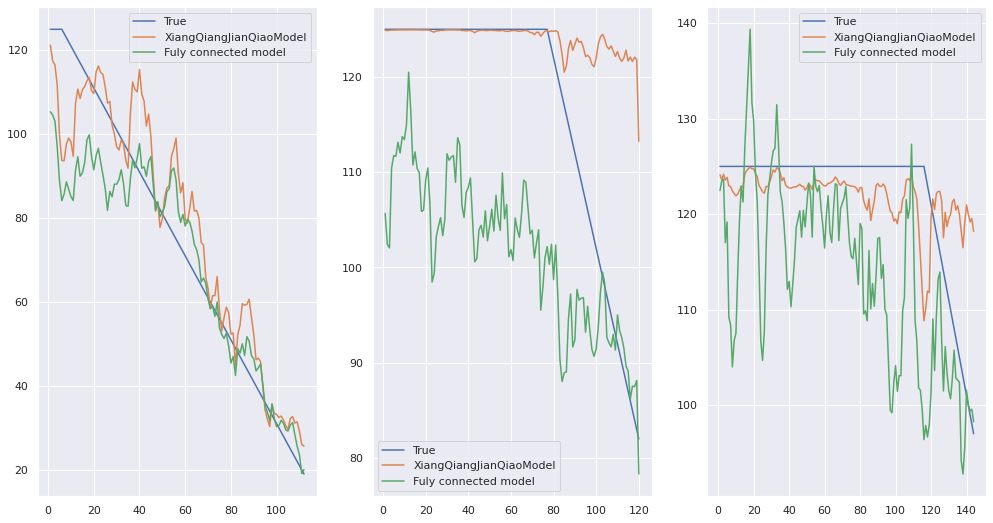

In [62]:
plot_predictions_grid([result_xqjq, result_fc], figsize=(17, 9))

## Model comparison and evaluation

One of the most important issues regarding PM is the ability to compare and evaluate different methods.

The main data structure used in the results module is a dictionary in which each of the keys is the model name, and the elements are a list of PredictionResult. 
Each element of the model array is interpreted as a Fold in CV settings. If the array contains only one element it can be considered that the evaluation has been made on a hold-out set.





The first step is to construct our data structure. Since we evaluated in a hold-out set, each list of each model will contain only one element.

In [68]:
results = {
    'FCN': [ result_fc],
    'XiangQiangJianQiao': [result_xqjq]
}

### Bar Plot

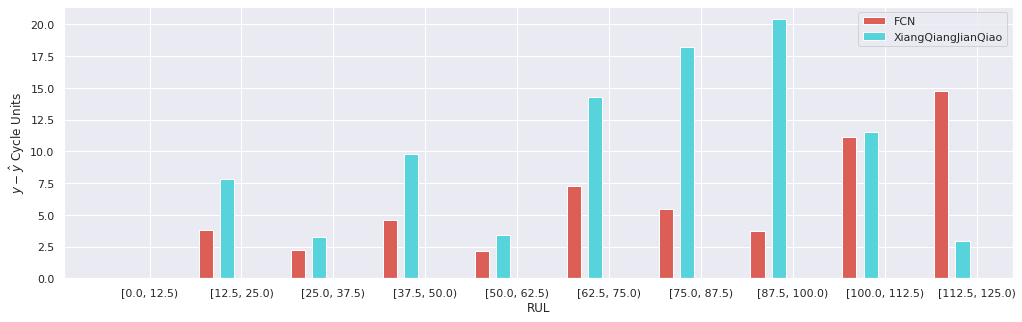

In [70]:
from ceruleo.graphics.plots import barplot_errors_wrt_RUL, boxplot_errors_wrt_RUL
barplot_errors_wrt_RUL(results, 10, figsize=(17, 5), y_axis_label=' Cycle Units');

### Box Plot

ValueError: List of boxplot statistics and `positions` values must have same the length

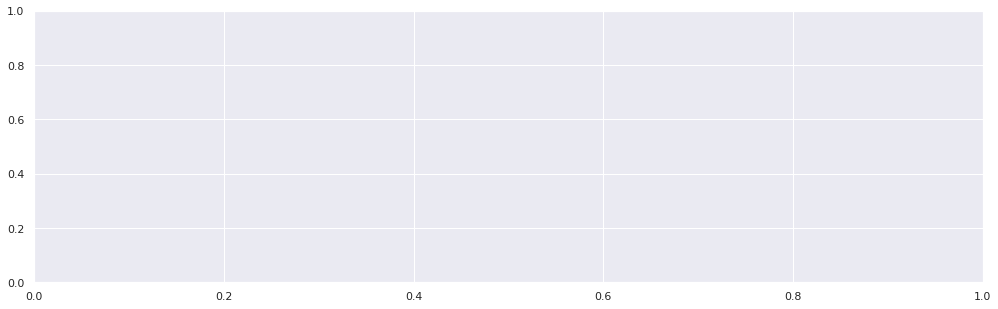

In [71]:
boxplot_errors_wrt_RUL(results, 10, figsize=(17, 5), y_axis_label=' Cycle Units');

### 
Additionally to the regression error, it is possible to compute some metrics more easily interpretable. In this context, two metrics were defined in [1], namely:

- Frequency of Unexpected Breaks (ρUB) - the percentage of failures not prevented;
- Amount of Unexploited Lifetime (ρUL) - the average number of time that could have been run before failure if the preventative maintenance suggested by the maintenance management mod-ule had not been performed.

A comparison between the predicted end of life with respect to the true end of that particular life is made. 

In that case, three scenarios can happen:
- The predicted end of life occurs before the true one. In that case, the predictions were pessimistic and the tool could have been used more time.
- The remaining useful life arrives at zero after the true remaining useful life. In that case, we incur the risk of the tool breaking.  
- The predicted line coincides with the true line. In that case, we don’t have unexploited time, and the risk of breakage can be considered 0.


Since usually the breakages are considered more harmful, a possible approach to preventing unexpected failures is to consider a more conservative maintenance approach, providing maintenance tasks recommendations some time before the end of life predicted. In that way, a conservative window can be defined in which the recommendation of making maintenance task should be performed at time T-predicted - conservative window size.

It is possible to visualize how it grows the unexploited lifetime grows as the conservative window size grows and how the unexpected breaks decrease as the conservative window size grows.





[1] Machine Learning for Predictive Maintenance: A Multiple Classifiers Approach
    Susto, G. A., Schirru, A., Pampuri, S., McLoone, S., & Beghi, A. (2015). 

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(17, 5))
plot_unexploited_lifetime(results, max_window=50, n=250, ax=ax[0], units=' [Cycle units]')
plot_unexpected_breaks(results, max_window=50, n=250, ax=ax[1], units=' [Cycle units]')

### Comparison with baseline models
Another important issue to consider when comparing models is to evaluate the models with respect to preventive maintenance approaches. RUL-PM provides `BaselineModel` that computes the mean and the median duration from the true targets of the data. `BaselineModel` uses a `LifeDatasetIterator`, that as its names indicate, iterate over each life, transforming it.

#### Baseline models creation

In [ ]:
mean_baseline_model = BaselineModel(mode='mean', RUL_threshold=125)
median_baseline_model = BaselineModel(mode='median', RUL_threshold=125)

#### Fitting baseline models

In [ ]:
life_iterator = LifeDatasetIterator(train_dataset, functional_transformer)

mean_baseline_model.fit(life_iterator)
median_baseline_model.fit(life_iterator)

In [ ]:
life_iterator = LifeDatasetIterator(validation_dataset, functional_transformer)
y_pred_mean = mean_baseline_model.predict(life_iterator)
y_true_mean = true_values(life_iterator)


y_pred_median = median_baseline_model.predict(life_iterator)
y_true_median = true_values(life_iterator)

In [ ]:
results_baseline = {
    'Mean baseline': [
        {
            'true': y_true_mean,
            'predicted': y_pred_mean
        }
    ],
    'Median baseline': [
        {
            'true': y_true_median,
            'predicted': y_pred_median
        }
    ]
}

In [ ]:
ax = plot_true_and_predicted(
    results_baseline,
    units='Units Cycle',
    figsize=(17, 5))
ax.set_xlim(0, 3500);


In [ ]:

lives = split_lives(y_true_median, y_pred_median, RUL_threshold=125)
life1 = 82
life2 = 33
fig, ax = plt.subplots(1, 2, figsize=(17, 5))
plot_life(lives[life1], units='Units Cycle', add_fitted=True, ax=ax[0])
plot_life(lives[life2], units='Units Cycle', add_fitted=True, ax=ax[1])


pd.DataFrame({
    'MAE': [lives[life1].mae(), lives[life2].mae()],
    'RMSE': [lives[life1].rmse(), lives[life2].rmse()],
    'Unexpected Break': [lives[life1].unexpected_break(), lives[life2].unexpected_break()],
    'Unexploited lifetime': [lives[life1].unexploited_lifetime(), lives[life2].unexploited_lifetime()]
},
index=['Life 1', 'Life 2'])

### Comparison with the full set of models

#### Regression metrics

In [ ]:
pd.DataFrame(cv_regression_metrics(results)).T[['mean']]

#### Maintenance metrics

In [ ]:
results.update(results_baseline)

fig, ax = plt.subplots(1, 2, figsize=(17, 5))
plot_unexploited_lifetime(results, max_window=50, n=250, ax=ax[0], units=' [Cycle units]')
plot_unexpected_breaks(results, max_window=50, n=250, ax=ax[1], units=' [Cycle units]');